<a href="https://colab.research.google.com/github/ranja-sarkar/DecisionTree/blob/main/Anomaly_Detection_IF_LOF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Isolation Forest


**An unsupervised ensemble works on the principle of decision tree algorithm.
It isolates outliers by randomly selecting a feature (or multiple features) from the given dataset, then randomly selecting a split value between the max. & min. of the selected feature, producing paths in trees of outliers (anomalies) where path length is the number of edges from the root (parent) node to terminal node. Hence dataset is partitioned and average of all path lengths decides whether a datapoint is inlying (normal) or outlying.**


>> DISCLAIMER: Before I proceed, I'd like to mention 1 common misconception that anomaly labels are readily available. In manufacturing industries, even plant engineers often cannot definitively label events as anomalies. They only reflect their assumptions about an anomaly, only a few can do this for specific equipment classes. So the anomaly detection exercise in general remains a classification task.

**Model Parameters:**

1) features to train each tree (default = 1.0)
 -> **max_features**

2) trees that will be built in the forest (default = 100)
 -> **n_estimators**

3) samples to be drawn to train each tree
 -> **max_samples = 'auto'**

4) expected proportion of outliers in dataset (threshold percent/fraction on the sample score)
 -> **contamination**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor

> **Time-series data**

In [2]:
df1 = pd.read_csv('CurrentVoltage.csv', parse_dates = ['DeviceTimeStamp'])
df1 = df1.dropna(how = 'any', axis = 0)              #remove empty rows in any
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19352 entries, 0 to 19351
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   DeviceTimeStamp  19352 non-null  datetime64[ns]
 1   VL1              19352 non-null  float64       
 2   VL2              19352 non-null  float64       
 3   VL3              19352 non-null  float64       
 4   IL1              19352 non-null  float64       
 5   IL2              19352 non-null  float64       
 6   IL3              19352 non-null  float64       
 7   VL12             19352 non-null  float64       
 8   VL23             19352 non-null  float64       
 9   VL31             19352 non-null  float64       
 10  INUT             19352 non-null  float64       
dtypes: datetime64[ns](1), float64(10)
memory usage: 1.6 MB


**Investigating neutral current (INUT) in a power device for outliers here.**

               INUT
count  19352.000000
mean      26.315187
std       15.103268
min        0.000000
25%       16.800000
50%       25.600000
75%       35.700000
max      145.800000


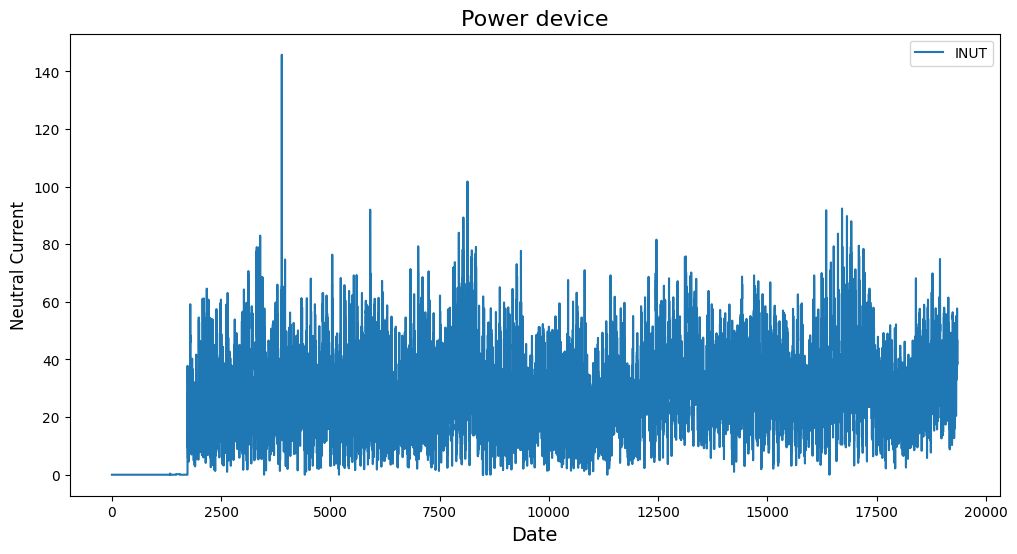

In [3]:
def plot_neutral(df):
    """
    Function: Shows summary statistics, plots neutral current
    Input: Dataframe
    Output: Plot
    """

    #df.set_index('DeviceTimeStamp', inplace = True)
    df['Date'] = df.index

    plt.figure(figsize = (12, 6))
    plt.xlabel('Date', fontsize = 14)
    plt.ylabel('Neutral Current', fontsize = 12)

    print(df[['INUT']].describe())
    plt.plot(df['Date'], df['INUT'], label = 'INUT')

    plt.title('Power device', fontsize = 16)
    plt.legend()
    plt.show()

plot_neutral(df1)

**High values (non-zero) of neutral current implies highly unbalanced system/load, hence needs correction.**

Text(0.5, 1.0, 'Lag in time-series')

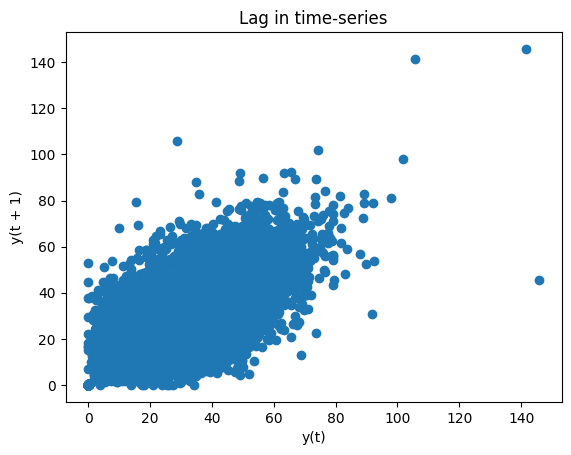

In [4]:
pd.plotting.lag_plot(df1['INUT'])
plt.title('Lag in time-series')

In [5]:
#df1['INUT'].cumsum().plot()                     #cumulative plot

mini, maxi = df1['INUT'].min(), df1['INUT'].max()
mm = round(df1['INUT'].mean(), 2)
print('Mean neutral current = ', mm)
print('Minimum neutral current = ', mini)
print('Maximum neutral current = ', maxi)

Mean neutral current =  26.32
Minimum neutral current =  0.0
Maximum neutral current =  145.8


> The Model

In [6]:
#initiate the model with 5% contamination

model = IsolationForest(random_state = 0, contamination = float(0.05))
model.fit(df1[['INUT']])

IsolationForest(contamination=0.05, random_state=0)

In [7]:
#negative anomaly scores mean anomalies and positive scores mean normal datapoints

df1['score'] = model.decision_function(df1[['INUT']])
df1['anomaly_value'] = model.predict(df1[['INUT']])
df1.head()

,DeviceTimeStamp,VL1,VL2,VL3,IL1,IL2,IL3,VL12,VL23,VL31,INUT,Date,score,anomaly_value
0,2019-06-25 13:06:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.088913,1
1,2019-06-27 10:49:00,238.7,238.7,238.8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.088913,1
2,2019-06-27 10:51:00,238.4,238.5,238.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,0.088913,1
3,2019-06-27 10:52:00,239.9,240.0,240.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,0.088913,1
4,2019-06-27 10:52:00,239.9,240.0,240.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,0.088913,1


anomaly_value
 1    18393
-1      959
Name: count, dtype: int64


Text(0.5, 1.0, 'Isolation Forest with 5% contamination')

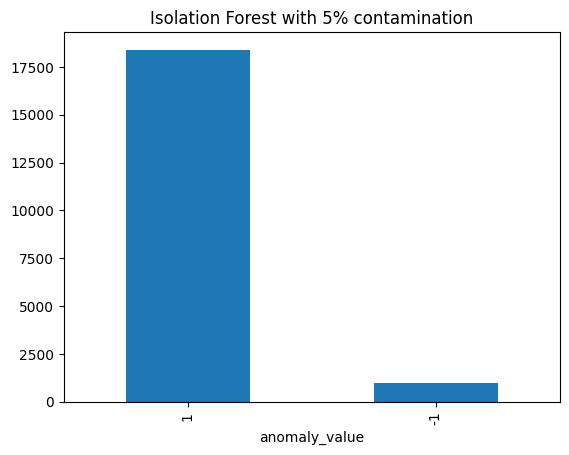

In [8]:
#datapoints classified -1 are anomalous

print(df1['anomaly_value'].value_counts())
df1['anomaly_value'].value_counts().plot(kind = 'bar')
plt.title('Isolation Forest with 5% contamination')

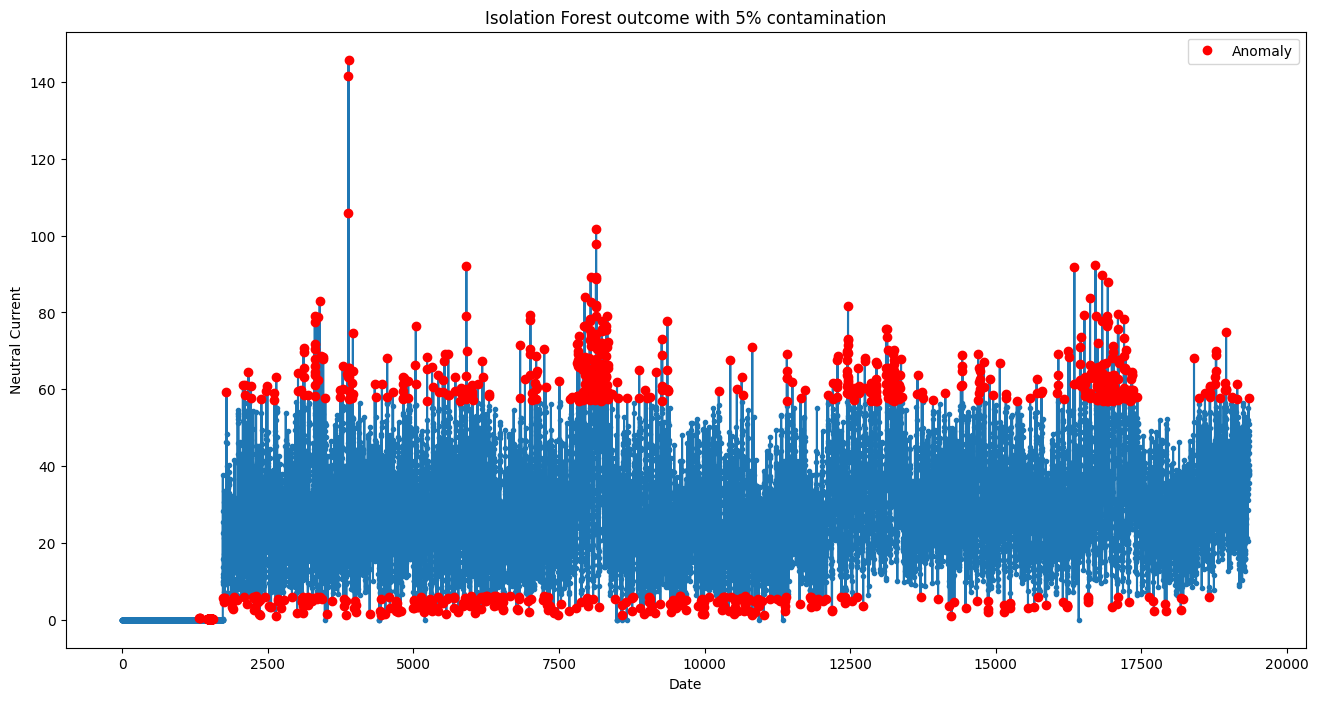

In [9]:
anomalies = df1.loc[df1['anomaly_value'] == -1]
outlier_index = list(anomalies.index)

plt.figure(figsize = (16, 8))
plt.plot(df1['INUT'], marker = '.')
plt.plot(anomalies['INUT'], 'o', color = 'red', label = 'Anomaly')
plt.title('Isolation Forest outcome with 5% contamination')
plt.xlabel('Date')
plt.ylabel('Neutral Current')
plt.legend()

**Let me try another contamination level (1%) - it is kinda intuitive that INUT values closer to zero are not outliers.**

anomaly_value
 1    19158
-1      194
Name: count, dtype: int64


Text(0.5, 1.0, 'Isolation Forest with 1% contamination')

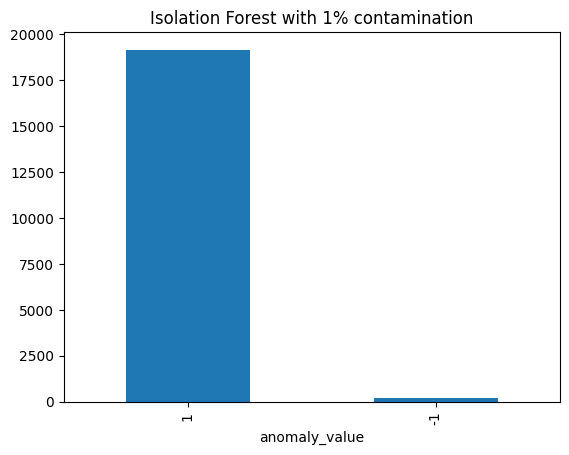

In [10]:
model = IsolationForest(random_state = 0, contamination = float(0.01))
model.fit(df1[['INUT']])

df1['score'] = model.decision_function(df1[['INUT']])
df1['anomaly_value'] = model.predict(df1[['INUT']])
#df1.head()

print(df1['anomaly_value'].value_counts())
df1['anomaly_value'].value_counts().plot(kind = 'bar')
plt.title('Isolation Forest with 1% contamination')

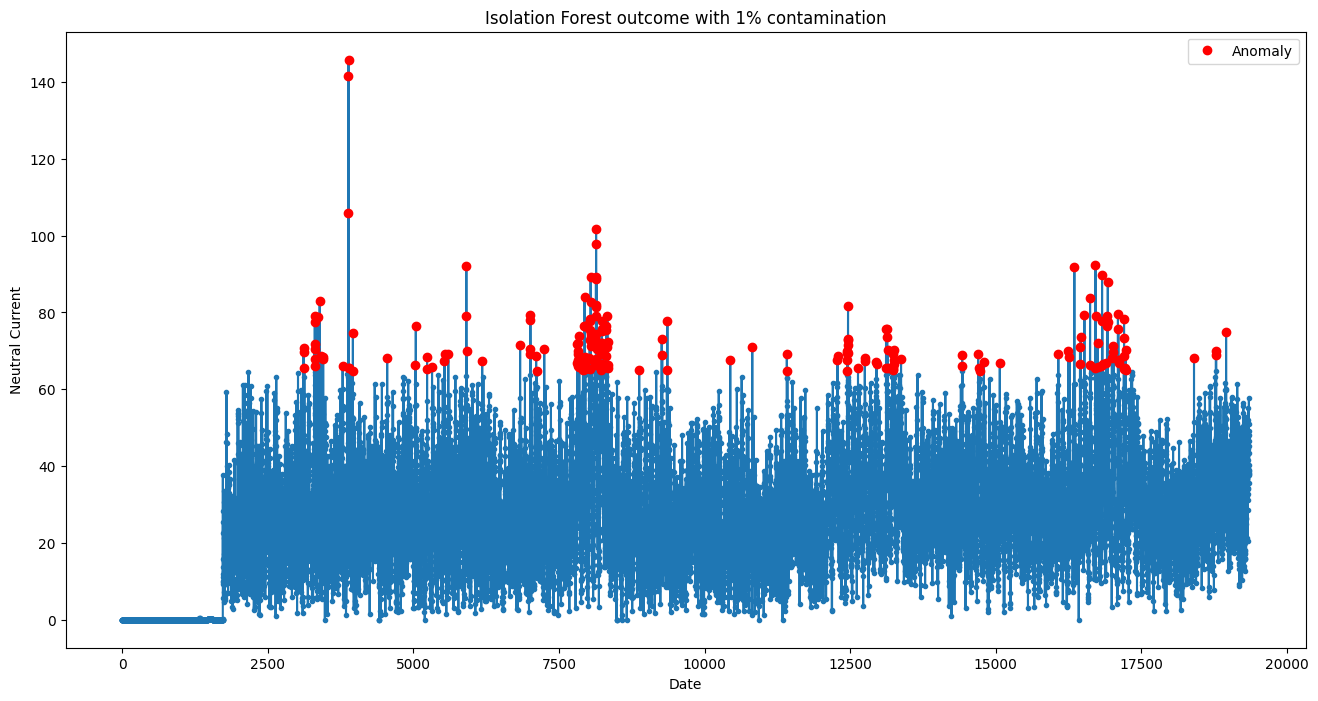

In [11]:
anomalies = df1.loc[df1['anomaly_value'] == -1]
outlier_index = list(anomalies.index)

plt.figure(figsize = (16, 8))
plt.plot(df1['INUT'], marker = '.')
plt.plot(anomalies['INUT'], 'o', color = 'red', label = 'Anomaly')
plt.title('Isolation Forest outcome with 1% contamination')
plt.xlabel('Date')
plt.ylabel('Neutral Current')
plt.legend()

In [12]:
clean_data = df1[df1['anomaly_value'] != -1]

mini, maxi = clean_data['INUT'].min(), clean_data['INUT'].max()
mm = round(clean_data['INUT'].mean(), 2)
print('Mean neutral current = ', mm)
print('Minimum neutral current = ', mini)
print('Maximum neutral current = ', maxi)

Mean neutral current =  25.85
Minimum neutral current =  0.0
Maximum neutral current =  64.7


Text(0.5, 0, 'Date')

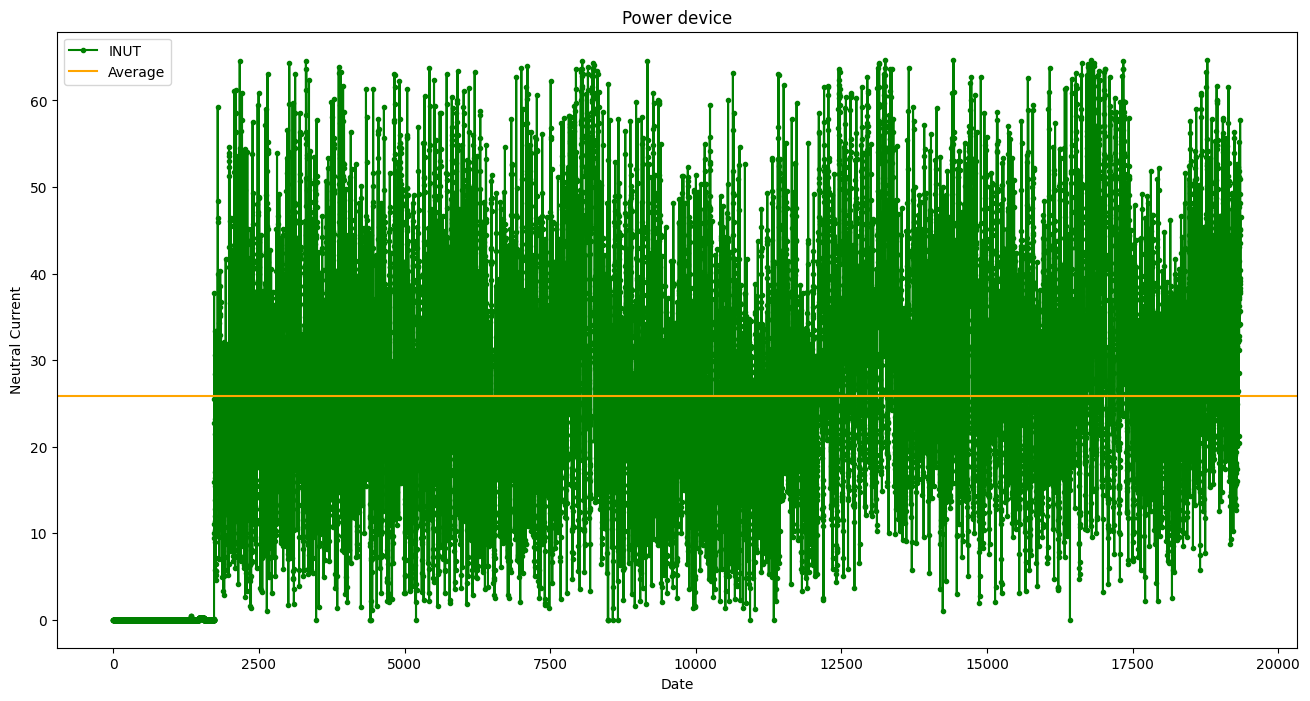

In [13]:
plt.figure(figsize = (16, 8))
plt.plot(clean_data['INUT'], marker = '.', label = 'INUT', color = 'green')
plt.axhline(y = mm, color = 'orange', linestyle = '-', label = 'Average')
plt.legend()
plt.title('Power device')
plt.ylabel('Neutral Current')
plt.xlabel('Date')

> **Amount of allowed contamination depends on the problem at hand. The business context and understanding comes in handy here.**

> **Data resampling** (from minutes to hours)

In [14]:
df_re = pd.read_csv('CurrentVoltage.csv', parse_dates = ['DeviceTimeStamp'])
df_re = df_re.dropna(how = 'any', axis = 0)                  #remove empty rows in any

df_re = df_re.drop(['VL1', 'VL2', 'VL3', 'IL1', 'IL2', 'IL3', 'VL12','VL23', 'VL31'], axis = 1)
df_re.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19352 entries, 0 to 19351
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   DeviceTimeStamp  19352 non-null  datetime64[ns]
 1   INUT             19352 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 302.5 KB


/tmp/ipython-input-15-4280082054.py:11: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  new_data['INUT'] = df['INUT'].resample('H').mean().ffill()    #hours granularity


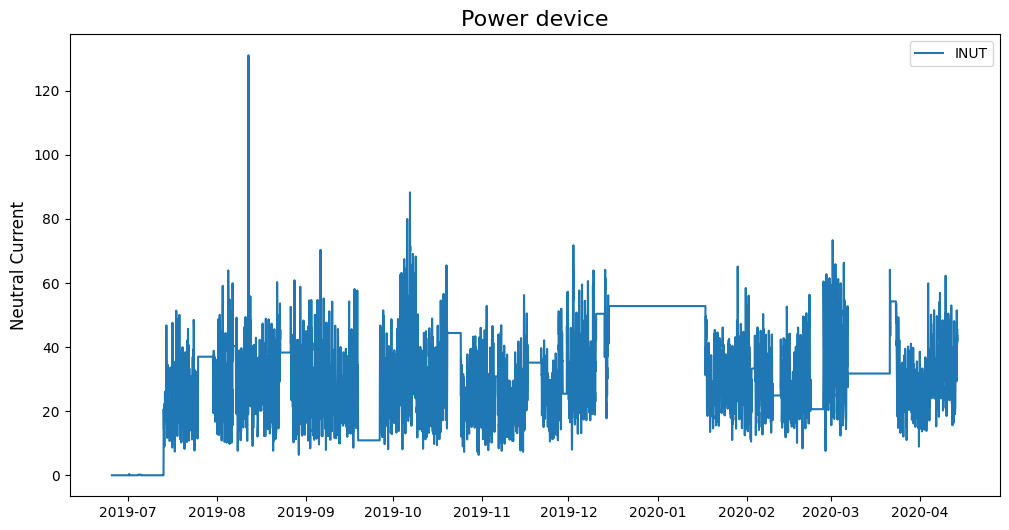

Resampled file created.


In [15]:
def resampled_data(df):
    """
    Function: Downsamples (high frequency to low frequency) input data
    Input: Dataframe
    Output: File + Plot
    """

    df.set_index('DeviceTimeStamp', inplace = True)
    #df['Date'] = df.index
    new_data = pd.DataFrame()
    new_data['INUT'] = df['INUT'].resample('H').mean().ffill()    #hours granularity
    new_data['Date'] = new_data.index
    new_data.to_csv('Resampled_inut.csv', index = False)

    plt.figure(figsize = (12, 6))
    #plt.xlabel('Date', fontsize = 14)
    plt.ylabel('Neutral Current', fontsize = 12)
    plt.plot(new_data['Date'], new_data['INUT'], label = 'INUT')
    plt.title('Power device', fontsize = 16)
    plt.legend()
    plt.show()

    return print('Resampled file created.')

resampled_data(df_re)

In [16]:
resampled = pd.read_csv('./Resampled_inut.csv')
dff = resampled.copy()                         #make a dataframe copy

resampled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7044 entries, 0 to 7043
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   INUT    7044 non-null   float64
 1   Date    7044 non-null   object 
dtypes: float64(1), object(1)
memory usage: 110.2+ KB


Text(0.5, 1.0, 'Lag in time-series')

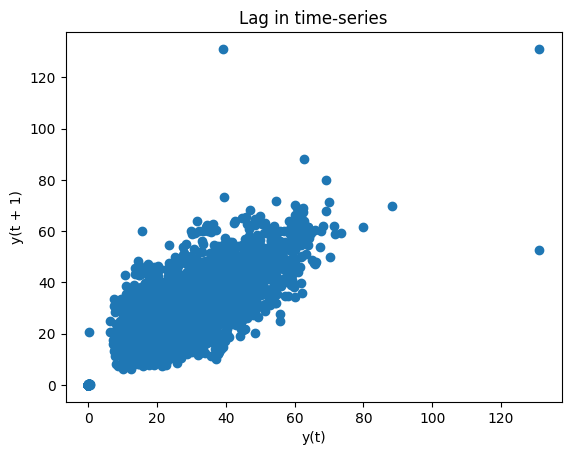

In [17]:
pd.plotting.lag_plot(resampled['INUT'])
plt.title('Lag in time-series')

>> 1% contamination

anomaly_value
 1    6975
-1      69
Name: count, dtype: int64


Text(0.5, 1.0, 'Isolation Forest with 1% contamination (resampled data)')

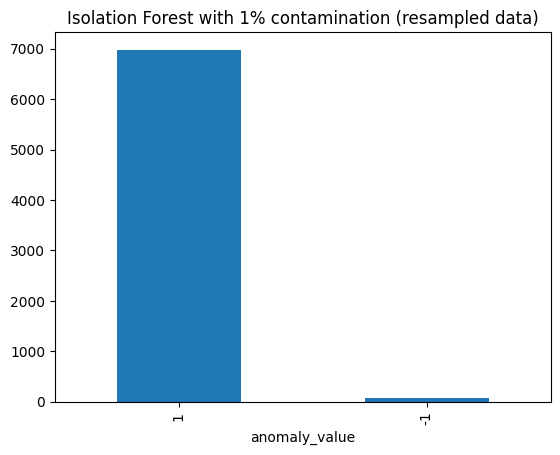

In [18]:
model = IsolationForest(random_state = 0, contamination = float(0.01))
model.fit(resampled[['INUT']])

resampled['score'] = model.decision_function(resampled[['INUT']])
resampled['anomaly_value'] = model.predict(resampled[['INUT']])

#datapoints classified -1 are anomalous
print(resampled['anomaly_value'].value_counts())
resampled['anomaly_value'].value_counts().plot(kind = 'bar')
plt.title('Isolation Forest with 1% contamination (resampled data)')

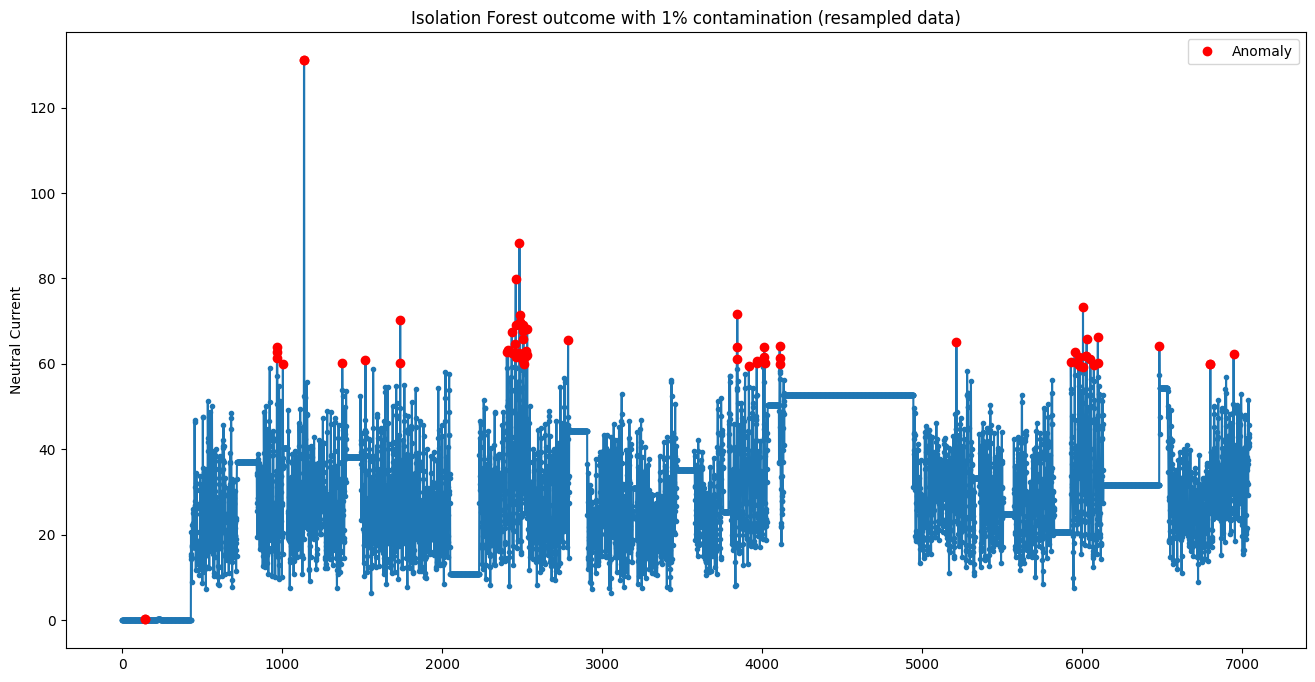

In [19]:
outliers = resampled.loc[resampled['anomaly_value'] == -1]
outlier_index = list(outliers.index)

plt.figure(figsize = (16, 8))
plt.plot(resampled['INUT'], marker = '.')
plt.plot(outliers['INUT'], 'o', color = 'red', label = 'Anomaly')
plt.title('Isolation Forest outcome with 1% contamination (resampled data)')
plt.ylabel('Neutral Current')
plt.legend()

>> **Better results!!**

# Local Outlier Factor

>> The LOF algorithm is an unsupervised anomaly detection method which computes the local density deviation of a given data point with respect to its neighbors. It considers as outliers the samples that have a substantially lower density than their neighbors.

>> **The Data**

In [20]:
dff.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7044 entries, 0 to 7043
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   INUT    7044 non-null   float64
 1   Date    7044 non-null   object 
dtypes: float64(1), object(1)
memory usage: 110.2+ KB


In [21]:
clf = LocalOutlierFactor(n_neighbors = 100, contamination = 0.01)               #1% contamination
y_pred = clf.fit_predict(dff[['INUT']])

/usr/local/lib/python3.11/dist-packages/sklearn/neighbors/_lof.py:322: UserWarning: Duplicate values are leading to incorrect results. Increase the number of neighbors for more accurate results.
  warnings.warn(


In [23]:
factors = clf.negative_outlier_factor_  #abnormality scores of the training samples
print(factors)

[-1.00000000e+00 -1.00000000e+00 -1.00000000e+00 ... -1.38929800e+00
 -1.10150436e+00 -2.96273335e+08]


>> https://scikit-learn.org/stable/modules/outlier_detection.html#outlier-detection

In [28]:
c1 = (factors == -1).sum()
c2 = (factors < -1).sum()
c3 = (factors > -1).sum()
print(c1, c2, c3)

2201 3306 1537


In [25]:
normal = (y_pred != -1).sum()
anomalies = (y_pred == -1).sum()          #datapoints classified -1 are anomalous
print(normal, anomalies)

6973 71


In [29]:
clf.get_params()

{'algorithm': 'auto',
 'contamination': 0.01,
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 100,
 'novelty': False,
 'p': 2}

In [26]:
resampled_clean = resampled[resampled['anomaly_value'] != -1]
#resampled_clean.head()

#plt.figure(figsize = (16, 8))
#plt.plot(resampled_clean['INUT'], marker = '.', label = 'INUT', color = 'green')
#plt.axhline(y = mm, color = 'orange', linestyle = '-', label = 'Average')
#plt.legend()
#plt.title('Power device')
#plt.ylabel('Neutral Current')

In [27]:
mini, maxi = resampled_clean['INUT'].min(), resampled_clean['INUT'].max()
mm = round(resampled_clean['INUT'].mean(), 2)
print('Mean neutral current = ', mm)
print('Minimum neutral current = ', mini)
print('Maximum neutral current = ', maxi)

Mean neutral current =  30.1
Minimum neutral current =  0.0
Maximum neutral current =  59.3


**The maximum INUT reduced to from 65 units to 59 upon resampling, with the avg. INUT increasing from 26 units to 30. With or without resampling, removal of outliers led to a reasonable maximum INUT in the device, which was otherwise unreasonably high (146 units) with the average INUT remaining more or less intact.**